<a href="https://colab.research.google.com/github/kiril-buga/Neural-Network-Training-Project/blob/main/1D_CNN_Multilabel_19_Classes_V3/Y_1d_CNN_19_Labels_FullLength_v03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enhanced 1D CNN for 19-Class Multi-Label ECG Classification (v03)

**Key Features:**
- 19-class multi-label classification (18 cardiac diseases + Healthy)
- **Full-length variable recordings** (5-120 seconds, no windowing)
- Enhanced architecture: Squeeze-Excitation blocks + Temporal Attention
- Focal loss for class imbalance
- **Outputs show disease names only** (not ICD codes)

**Architecture:** 64→128→256→512 filters + SE + Attention + Adaptive Pooling

## 1. Setup & Dependencies

In [4]:
# Install dependencies
!pip install wfdb neurokit2 h5py tensorflow scikit-learn matplotlib seaborn pandas numpy scipy -q

print("✓ Dependencies installed")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 88.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
✓ Dependencies installed


In [5]:
# Imports
import os
import json
import numpy as np
import pandas as pd
import h5py
import wfdb
from scipy.signal import butter, filtfilt, resample
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, hamming_loss, confusion_matrix, classification_report
)

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")
print("✓ Imports complete")

TensorFlow version: 2.19.0
Num GPUs Available: 1
✓ Imports complete


In [6]:
# ============================================================================
# MEMORY OPTIMIZATION: ECG Augmentation Functions
# ============================================================================
# OPTIONAL: These functions enable data augmentation for minority classes
# Currently DISABLED by default to avoid training overhead
# Enable by setting augment=True in create_optimized_dataset() calls
def augment_ecg_noise(signal, snr_db=25):
    """Add Gaussian noise with specified SNR"""
    signal_power = np.mean(signal ** 2)
    noise_power = signal_power / (10 ** (snr_db / 10))
    noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)
    return signal + noise

def augment_ecg_time_shift(signal, fs=500, max_shift_ms=200):
    """Shift signal in time by random amount"""
    max_shift_samples = int(max_shift_ms * fs / 1000)
    shift = np.random.randint(-max_shift_samples, max_shift_samples + 1)
    if shift > 0:
        return np.pad(signal, ((shift, 0), (0, 0)), mode='edge')[:-shift]
    elif shift < 0:
        return np.pad(signal, ((0, -shift), (0, 0)), mode='edge')[-shift:]
    return signal

def augment_ecg_amplitude(signal, scale_range=(0.9, 1.1)):
    """Scale amplitude randomly"""
    scale = np.random.uniform(*scale_range)
    return signal * scale

def augment_ecg_baseline_wander(signal, fs=500, freq_range=(0.1, 0.5), amplitude=0.05):
    """Add realistic baseline wander"""
    freq = np.random.uniform(*freq_range)
    t = np.arange(signal.shape[0]) / fs
    wander = amplitude * np.sin(2 * np.pi * freq * t)
    return signal + wander[:, np.newaxis]

def augment_ecg(signal, p=0.8):
    """
    Apply random augmentations to ECG signal.

    Args:
        signal: (length, channels) array
        p: probability of applying each augmentation

    Returns:
        Augmented signal
    """
    signal = signal.copy()

    if np.random.random() < p:
        signal = augment_ecg_noise(signal, snr_db=np.random.uniform(20, 30))
    if np.random.random() < p * 0.7:
        signal = augment_ecg_time_shift(signal)
    if np.random.random() < p * 0.6:
        signal = augment_ecg_amplitude(signal)
    if np.random.random() < p * 0.4:
        signal = augment_ecg_baseline_wander(signal)

    return signal

print("✓ Augmentation functions defined")

✓ Augmentation functions defined


In [7]:
# ============================================================================
# MEMORY OPTIMIZATION: Lazy HDF5 Data Loader
# ============================================================================
# Loads samples on-demand instead of loading everything into RAM
# RAM savings: ~18 GB → ~0.5 GB

class LazyHDF5Loader:
    """
    Lazy loader for HDF5 data - keeps file open and loads samples on-demand.
    Dramatically reduces RAM usage.
    """
    def __init__(self, h5_file_path):
        self.h5_file_path = h5_file_path
        self.h5_file = None
        self._load_metadata()

    def _load_metadata(self):
        """Load only metadata (labels, lengths, bin indices)"""
        with h5py.File(self.h5_file_path, 'r') as h5f:
            self.y_all = []
            self.lengths_all = []
            self.bin_indices = []  # (bin_name, index_within_bin)

            for bin_name in sorted(h5f.keys()):
                if not bin_name.startswith('bin_'):
                    continue

                grp = h5f[bin_name]
                y_bin = grp['y'][:]  # Labels are small, OK to load
                lengths_bin = grp['lengths'][:]

                for i in range(len(y_bin)):
                    self.y_all.append(y_bin[i])
                    self.lengths_all.append(lengths_bin[i])
                    self.bin_indices.append((bin_name, i))

            self.y_all = np.array(self.y_all)
            self.lengths_all = np.array(self.lengths_all)

        print(f"✓ Loaded metadata for {len(self.y_all)} samples (minimal RAM)")

    def __len__(self):
        return len(self.y_all)

    def __getitem__(self, idx):
        """Load a single sample on-demand"""
        if self.h5_file is None:
            self.h5_file = h5py.File(self.h5_file_path, 'r')

        bin_name, bin_idx = self.bin_indices[idx]
        grp = self.h5_file[bin_name]

        # Load only this sample
        X = grp['X'][bin_idx, :self.lengths_all[idx], :]
        y = self.y_all[idx]

        return X, y, self.lengths_all[idx]

    def close(self):
        if self.h5_file is not None:
            self.h5_file.close()
            self.h5_file = None

    def __del__(self):
        self.close()

print("✓ LazyHDF5Loader class defined")

✓ LazyHDF5Loader class defined


In [8]:
# ============================================================================
# MEMORY OPTIMIZATION: Calculate Oversampling Rates
# ============================================================================
# Uses index-based sampling instead of duplicating data

def calculate_oversample_rates(y_data, target_samples_per_class=None):
    """
    Calculate how many times to repeat each sample to balance classes.

    Args:
        y_data: (n_samples, n_classes) one-hot encoded labels
        target_samples_per_class: Target number per class (default: max class count)

    Returns:
        oversample_rates: Array of repetition counts for each sample
    """
    class_counts = y_data.sum(axis=0)
    class_labels = y_data.argmax(axis=1)

    if target_samples_per_class is None:
        # Use the largest disease class (not Healthy)
        healthy_idx = np.where(np.array(DISEASE_NAMES) == 'Healthy')[0][0]
        disease_counts = [class_counts[i] for i in range(len(class_counts)) if i != healthy_idx]
        target_samples_per_class = int(max(disease_counts))

    print(f"\nOversampling strategy:")
    print(f"  Target samples per class: {target_samples_per_class}")

    oversample_rates = np.ones(len(y_data), dtype=np.int32)

    for class_idx in range(len(class_counts)):
        class_mask = (class_labels == class_idx)
        count = int(class_counts[class_idx])

        if count == 0:
            continue

        # Calculate repetition rate
        if DISEASE_NAMES[class_idx] == 'Healthy':
            # Undersample Healthy to target
            rate = 1  # Don't oversample Healthy
        else:
            # Oversample diseases to target
            rate = max(1, int(target_samples_per_class / count))

        oversample_rates[class_mask] = rate

        print(f"  {DISEASE_NAMES[class_idx]:40s}: {count:5d} samples × {rate:2d} = {count * rate:5d}")

    return oversample_rates

print("✓ Oversampling calculation function defined")

✓ Oversampling calculation function defined


## 1.1 GPU Configuration

In [9]:
# GPU Configuration - Optimized for Colab T4 GPU (15 GB)
import tensorflow as tf
import os

# Enable memory growth (allocate GPU memory dynamically)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✓ GPU memory growth enabled: {gpus[0].name}")
        print(f"✓ Num GPUs Available: {len(gpus)}")
    except RuntimeError as e:
        print(f"GPU configuration error: {e}")
else:
    print("⚠️  WARNING: No GPU detected! Training will be VERY slow.")
    print(f"   Current TensorFlow version: {tf.__version__}")

✓ GPU memory growth enabled: /physical_device:GPU:0
✓ Num GPUs Available: 1


In [10]:
# ALTERNATIVE: If GPU still fails, set memory limit or force CPU

# Option 1: Set explicit GPU memory limit (use only 2GB of your 4GB GPU)
# Uncomment these lines if the error persists:

# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#         tf.config.set_logical_device_configuration(
#             gpus[0],
#             [tf.config.LogicalDeviceConfiguration(memory_limit=2048)])  # 2GB limit
#         print("✓ GPU memory limited to 2048MB")
#     except RuntimeError as e:
#         print(f"Memory limit error: {e}")

# Option 2: Force CPU-only mode (FALLBACK if GPU continues to fail)
# Uncomment this line to disable GPU entirely:

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
# print("⚠️  GPU DISABLED - Using CPU only (will be slower)")

print("ℹ️  GPU troubleshooting options available (see cell comments)")


ℹ️  GPU troubleshooting options available (see cell comments)


## 1.1 HuggingFace Setup (Optional)

In [11]:
# HuggingFace Setup (optional - set ENABLE_HF_UPLOAD=True to enable)
# Install huggingface_hub if not already installed
try:
    from huggingface_hub import HfApi, login, create_repo
except ImportError:
    print("Installing huggingface_hub...")
    import subprocess
    subprocess.run(['.venv\\Scripts\\python.exe', '-m', 'pip', 'install', 'huggingface-hub', '-q'], check=True)
    from huggingface_hub import HfApi, login, create_repo

# Set this to True to enable HuggingFace uploads
ENABLE_HF_UPLOAD = True  # Change to True to enable uploads

if ENABLE_HF_UPLOAD:
    from getpass import getpass
    from google.colab import userdata
    import os

    print("HuggingFace Setup")
    print("=" * 60)
    print("Please provide your Hugging Face token with WRITE access:")
    print("Get it from: https://huggingface.co/settings/tokens")
    print()

    # Try to get token from environment variable first
    HF_TOKEN = os.environ.get('HF_TOKEN') or userdata.get('HF_TOKEN')

    if not HF_TOKEN:
        HF_TOKEN = getpass("Enter your HF token (hidden): ")

    # Login
    try:
        login(token=HF_TOKEN, add_to_git_credential=True)
        print("✓ Logged in to Hugging Face")
    except Exception as e:
        print(f"❌ Login failed: {e}")
        print("HuggingFace uploads will be disabled")
        ENABLE_HF_UPLOAD = False

    if ENABLE_HF_UPLOAD:
        # Repository names
        MODEL_REPO = "Neural-Network-Project/ECG-Disease-Classifier"
        DATASET_REPO = "Neural-Network-Project/ECG-database"

        # Initialize API
        api = HfApi()

        # Ensure repos exist
        try:
            api.repo_info(repo_id=MODEL_REPO, repo_type="model")
            print(f"✓ Model repo exists: {MODEL_REPO}")
        except:
            try:
                create_repo(repo_id=MODEL_REPO, repo_type="model", private=False)
                print(f"✓ Created model repo: {MODEL_REPO}")
            except Exception as e:
                print(f"⚠️  Could not create model repo: {e}")

        try:
            api.repo_info(repo_id=DATASET_REPO, repo_type="dataset")
            print(f"✓ Dataset repo exists: {DATASET_REPO}")
        except:
            try:
                create_repo(repo_id=DATASET_REPO, repo_type="dataset", private=False)
                print(f"✓ Created dataset repo: {DATASET_REPO}")
            except Exception as e:
                print(f"⚠️  Could not create dataset repo: {e}")

        print("=" * 60)
else:
    print("HuggingFace uploads disabled (set ENABLE_HF_UPLOAD=True to enable)")
    MODEL_REPO = None
    DATASET_REPO = None
    api = None

HuggingFace Setup
Please provide your Hugging Face token with WRITE access:
Get it from: https://huggingface.co/settings/tokens

✓ Logged in to Hugging Face
✓ Model repo exists: Neural-Network-Project/ECG-Disease-Classifier
✓ Dataset repo exists: Neural-Network-Project/ECG-database


In [12]:
# ============================================================================
# DATA DOWNLOAD FROM HUGGINGFACE
# ============================================================================
# Downloads dataset from HuggingFace (works in Colab and local)

import os
from huggingface_hub import snapshot_download

# Configuration
DATASET_REPO = "Neural-Network-Project/ECG-database"  # Your HuggingFace dataset repo
DOWNLOAD_DATA = True  # Set to False if data already exists locally

if DOWNLOAD_DATA:
    print("Downloading dataset from HuggingFace...")
    print(f"  Repository: {DATASET_REPO}")
    print("  This may take a few minutes...")
    print()

    try:
        local_dir = snapshot_download(
            repo_id=DATASET_REPO,
            local_dir="../dataset",
            repo_type="dataset",
            allow_patterns=["data/**", "artifacts/**"],
            ignore_patterns=["artifacts/training_results/**"]
        )

        print(f"[OK] Dataset downloaded to: {local_dir}")
        print(f"  - Raw ECG data: {local_dir}/data/Child_ecg/")
        print(f"  - Metadata CSV: {local_dir}/data/AttributesDictionary.csv")
        print(f"  - Preprocessed H5: {local_dir}/artifacts/")
        print()

        # Set DATA_DIR to downloaded location
        DATA_DIR = local_dir + "/"
        print(f"[OK] DATA_DIR set to: {DATA_DIR}")

    except Exception as e:
        print(f"[ERROR] Failed to download dataset: {e}")
        print("Falling back to local path...")
        DATA_DIR = "../.data/"  # Fallback to local

else:
    print("[INFO] Using local data (DOWNLOAD_DATA=False)")
    DATA_DIR = "../.data/"  # Local path

print(f"\nFinal DATA_DIR: {DATA_DIR}")

  Repository: Neural-Network-Project/ECG-database
  This may take a few minutes...



Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

DiseaseCode.csv: 0.00B [00:00, ?B/s]

qc_summary.csv: 0.00B [00:00, ?B/s]

label_mapping.json: 0.00B [00:00, ?B/s]

AttributesDictionary.csv: 0.00B [00:00, ?B/s]

artifacts/X_windows.npy:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

data/Child_ecg.z01:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

data/Child_ecg.zip:   0%|          | 0.00/1.91G [00:00<?, ?B/s]

artifacts/y_labels.npy:   0%|          | 0.00/479k [00:00<?, ?B/s]

ECGCode.csv: 0.00B [00:00, ?B/s]

ExampleReadingCode.ipynb: 0.00B [00:00, ?B/s]

[OK] Dataset downloaded to: /dataset
  - Raw ECG data: /dataset/data/Child_ecg/
  - Metadata CSV: /dataset/data/AttributesDictionary.csv
  - Preprocessed H5: /dataset/artifacts/

[OK] DATA_DIR set to: /dataset/

Final DATA_DIR: /dataset/


In [13]:
# Configuration
NOTEBOOK_VERSION = "v03_balanced"  # Updated to distinguish from original
# DATA_DIR defined by HuggingFace download cell above
# If not using HF download, uncomment: # DATA_DIR = "../.data/"
ECG_DIR = os.path.join(DATA_DIR, "data/Child_ecg/")
CSV_PATH = os.path.join(DATA_DIR, "data/AttributesDictionary.csv")
OUTPUT_DIR = os.path.join(DATA_DIR, "multilabel_19v3/")  # New output directory
HDF5_FILE = os.path.join(DATA_DIR, "multilabel_19v3/ecg_full_length_19classes.h5")
MODEL_NAME = "1D_CNN_19Classes_multilabel_19v3"  # Updated model name

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Training parameters - OPTIMIZED FOR COLAB T4 GPU (15 GB VRAM)
MAX_LENGTH = 15000  # Maximum sequence length (30 seconds at 500Hz)
BATCH_SIZE = 128  # Optimized for T4 GPU - uses ~7-8 GB VRAM
EPOCHS = 100  # EarlyStopping will stop if no improvement
LEARNING_RATE = 2e-4
TARGET_FS = 500  # Target sampling frequency
TARGET_CHANNELS = 12
CHECKPOINT_EVERY = 1  # Save checkpoint every 5 epochs

print(f"Configuration:")
print(f"  Data directory: {DATA_DIR}")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Model name: {MODEL_NAME}")
print(f"  Max sequence length: {MAX_LENGTH} samples ({MAX_LENGTH/TARGET_FS:.1f}s)")
print(f"  Batch size: {BATCH_SIZE}")
# print(f"  Gradient accumulation steps: {GRADIENT_ACCUMULATION_STEPS} (effective batch_size={BATCH_SIZE*GRADIENT_ACCUMULATION_STEPS})")  # Not yet implemented
print(f"  Epochs: {EPOCHS}")
print(f"  Checkpoint every: {CHECKPOINT_EVERY} epochs (HuggingFace)")


Configuration:
  Data directory: /dataset/
  Output directory: /dataset/multilabel_19v3/
  Model name: 1D_CNN_19Classes_multilabel_19v3
  Max sequence length: 15000 samples (30.0s)
  Batch size: 128
  Epochs: 100
  Checkpoint every: 1 epochs (HuggingFace)


## 1.5 Extract Split Archive (if needed)

In [14]:
# Extract split archives if needed (local environment)
import os
import zipfile

# Check if Child_ecg directory exists and has files
def count_files_recursive(directory):
    """Count all files recursively in a directory"""
    if not os.path.exists(directory):
        return 0
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len(files)
    return count

ecg_file_count = count_files_recursive(ECG_DIR)

print(f"Checking ECG data extraction...")
print(f"  ECG directory: {ECG_DIR}")
print(f"  Files found: {ecg_file_count}")

# If directory doesn't exist or has very few files, extract the archives
if ecg_file_count < 1000:  # Expect tens of thousands of files
    print(f"\n⚠️  Insufficient ECG files detected. Checking for archives to extract...")

    # Look for split archive files
    archive_dir = os.path.join(DATA_DIR, "data")
    zip_file = os.path.join(archive_dir, "Child_ecg.zip")
    z01_file = os.path.join(archive_dir, "Child_ecg.z01")

    if os.path.exists(zip_file):
        print(f"\n✓ Found archive files:")
        print(f"  - {zip_file}")
        if os.path.exists(z01_file):
            print(f"  - {z01_file}")

        print(f"\nExtracting archives...")
        print(f"This may take several minutes...")

        try:
            # For split archives (.z01 + .zip), we need to use 7zip or similar
            if os.path.exists(z01_file):
                # Try using 7zip if available
                try:
                    import subprocess
                    # Try 7z command on Windows (usually installed with 7-Zip)
                    result = subprocess.run(
                        ['7z', 'x', zip_file, f'-o{archive_dir}', '-y'],
                        capture_output=True,
                        text=True
                    )
                    if result.returncode == 0:
                        print(f"✓ Successfully extracted using 7zip")
                    else:
                        raise Exception("7zip extraction failed")
                except:
                    # Fallback: Try PowerShell Expand-Archive (may not work with split archives)
                    print("7zip not available, trying PowerShell...")
                    result = subprocess.run(
                        ['powershell', '-Command',
                         f'Expand-Archive -Path "{zip_file}" -DestinationPath "{archive_dir}" -Force'],
                        capture_output=True,
                        text=True
                    )
                    if result.returncode == 0:
                        print(f"✓ Extraction attempted with PowerShell")
                    else:
                        print(f"PowerShell extraction failed, trying Python zipfile...")
                        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                            zip_ref.extractall(archive_dir)
                        print(f"✓ Extraction attempted with zipfile")
            else:
                # Single zip file, use Python's zipfile
                with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                    zip_ref.extractall(archive_dir)
                print(f"✓ Successfully extracted zip file")

            # Verify extraction
            new_file_count = count_files_recursive(ECG_DIR)
            print(f"\n✓ Extraction complete!")
            print(f"  Files extracted: {new_file_count}")

            if new_file_count < 1000:
                print(f"\n⚠️  Warning: Expected more files. Archive may not have extracted completely.")
                print(f"  Please manually extract {zip_file} using 7-Zip if needed.")

        except Exception as e:
            print(f"\n❌ Error during extraction: {e}")
            print(f"\nPlease manually extract the following file:")
            print(f"  {zip_file}")
            print(f"To directory: {archive_dir}")
            print(f"\nYou can use 7-Zip (https://www.7-zip.org/) to extract split archives.")
            raise
    else:
        print(f"\n❌ Archive files not found!")
        print(f"  Expected: {zip_file}")
        print(f"\nPlease ensure the archive files are present in {archive_dir}")
        raise FileNotFoundError(f"Archive not found: {zip_file}")
else:
    print(f"✓ ECG data already extracted ({ecg_file_count} files found)")

Checking ECG data extraction...
  ECG directory: /dataset/data/Child_ecg/
  Files found: 0

⚠️  Insufficient ECG files detected. Checking for archives to extract...

✓ Found archive files:
  - /dataset/data/Child_ecg.zip
  - /dataset/data/Child_ecg.z01

Extracting archives...
This may take several minutes...
✓ Successfully extracted using 7zip

✓ Extraction complete!
  Files extracted: 28380


## 2. Disease Mapping & Class Definitions

In [15]:
# ICD codes to Disease Names mapping
ICD_TO_DISEASE_NAME = {
    'I40.0': 'Fulminant/Viral Myocarditis',
    'I40.9': 'Acute Myocarditis',
    'I51.4': 'Myocarditis Unspecified',
    'I42.0': 'Dilated Cardiomyopathy',
    'I42.2': 'Hypertrophic Cardiomyopathy',
    'I42.9': 'Cardiomyopathy Unspecified',
    'Q24.8': 'Noncompaction Ventricular Myocardium',
    'M30.3': 'Kawasaki Disease',
    'Q21.0': 'Ventricular Septal Defect',
    'Q21.1': 'Atrial Septal Defect',
    'Q21.2': 'Atrioventricular Septal Defect',
    'Q21.3': 'Tetralogy of Fallot',
    'Q22.1': 'Pulmonary Valve Stenosis',
    'Q25.0': 'Patent Ductus Arteriosus',
    'Q25.6': 'Pulmonary Artery Stenosis',
    'I37.0': 'Pulmonary Valve Regurgitation',
    'I34.0': 'Mitral Valve Insufficiency',
    'Q24.9': 'Congenital Heart Malformation',
    'Healthy': 'Healthy'  # Changed from "No Disease (Healthy)" to just "Healthy"
}

# Disease names list (for model outputs - NO ICD codes in outputs)
DISEASE_NAMES = list(ICD_TO_DISEASE_NAME.values())
ICD_CODES = list(ICD_TO_DISEASE_NAME.keys())
NUM_CLASSES = len(DISEASE_NAMES)

# Disease grouping for interpretability
DISEASE_GROUPS = {
    'Myocarditis': ['I40.0', 'I40.9', 'I51.4'],
    'Cardiomyopathy': ['I42.0', 'I42.2', 'I42.9', 'Q24.8'],
    'Kawasaki': ['M30.3'],
    'CHD': ['Q21.0', 'Q21.1', 'Q21.2', 'Q21.3', 'Q22.1', 'Q25.0', 'Q25.6', 'I37.0', 'I34.0', 'Q24.9']
}

print(f"Number of classes: {NUM_CLASSES}")
print(f"\nDisease Names (outputs will show these names ONLY):")
for i, name in enumerate(DISEASE_NAMES, 1):
    print(f"  {i:2d}. {name}")

print(f"\nDisease Groups:")
for group, codes in DISEASE_GROUPS.items():
    names = [ICD_TO_DISEASE_NAME[code] for code in codes]
    print(f"  {group}: {len(codes)} diseases")

Number of classes: 19

Disease Names (outputs will show these names ONLY):
   1. Fulminant/Viral Myocarditis
   2. Acute Myocarditis
   3. Myocarditis Unspecified
   4. Dilated Cardiomyopathy
   5. Hypertrophic Cardiomyopathy
   6. Cardiomyopathy Unspecified
   7. Noncompaction Ventricular Myocardium
   8. Kawasaki Disease
   9. Ventricular Septal Defect
  10. Atrial Septal Defect
  11. Atrioventricular Septal Defect
  12. Tetralogy of Fallot
  13. Pulmonary Valve Stenosis
  14. Patent Ductus Arteriosus
  15. Pulmonary Artery Stenosis
  16. Pulmonary Valve Regurgitation
  17. Mitral Valve Insufficiency
  18. Congenital Heart Malformation
  19. Healthy

Disease Groups:
  Myocarditis: 3 diseases
  Cardiomyopathy: 4 diseases
  Kawasaki: 1 diseases
  CHD: 10 diseases


## 3. Data Preprocessing Functions

In [16]:
def apply_bandpass(x, fs, lowcut=0.5, highcut=40.0):
    """Apply bandpass filter to entire ECG signal."""
    if x.ndim == 1:
        x = x[:, None]
    nyq = 0.5 * fs
    b, a = butter(4, [lowcut/nyq, highcut/nyq], btype="band")
    return np.column_stack([filtfilt(b, a, x[:, i]) for i in range(x.shape[1])])


def process_full_recording(sig, meta, target_fs=500.0, target_channels=12, max_length=None):
    """
    Process full ECG recording without windowing.
    Handles variable lengths (5-120 seconds), with optional truncation.

    Args:
        sig: ECG signal
        meta: Metadata with sampling frequency
        target_fs: Target sampling frequency (Hz)
        target_channels: Target number of channels
        max_length: Maximum length in samples (default: None = no truncation)

    Returns:
        sig_processed: (n_samples, 12) - variable length
        length: actual sample count
    """
    # Get sampling frequency
    fs = meta.get("fs", None)
    if fs is None:
        fs = getattr(meta, "fs", None)
    if fs is None:
        raise ValueError("Missing sampling frequency")

    if sig.ndim == 1:
        sig = sig[:, None]

    # 1. Bandpass filter entire signal (0.5-40 Hz)
    sig_bp = apply_bandpass(sig, fs=fs)

    # 2. Resample to target_fs if needed
    if fs != target_fs:
        n_samples = sig_bp.shape[0]
        n_new = int(round(n_samples / fs * target_fs))
        sig_res = np.column_stack([resample(sig_bp[:, i], n_new)
                                   for i in range(sig_bp.shape[1])])
    else:
        sig_res = sig_bp

    # 3. Truncate if max_length specified (MEMORY OPTIMIZATION)
    if max_length is not None and sig_res.shape[0] > max_length:
        sig_res = sig_res[:max_length, :]

    # 4. Standardize to 12 leads (pad with zeros if fewer)
    if sig_res.shape[1] < target_channels:
        padded = np.zeros((sig_res.shape[0], target_channels), dtype=np.float32)
        padded[:, :sig_res.shape[1]] = sig_res
        sig_res = padded
    elif sig_res.shape[1] > target_channels:
        sig_res = sig_res[:, :target_channels]

    # 5. Z-score normalization per lead
    sig_norm = sig_res.copy()
    for ch in range(target_channels):
        x = sig_norm[:, ch]
        m, s = np.nanmean(x), np.nanstd(x)
        sig_norm[:, ch] = (x - m) / (s if s > 1e-6 else 1.0)

    actual_length = sig_norm.shape[0]

    return sig_norm.astype(np.float16), actual_length


def parse_icd_codes(s):
    """Parse semicolon-separated ICD codes from CSV."""
    if pd.isna(s):
        return []
    return [p.strip().replace("'", "").replace(")", "").split(")")[-1]
            for p in str(s).split(";") if p.strip()]


print("✓ Preprocessing functions defined")


✓ Preprocessing functions defined


## 4. Load and Preprocess Data

In [17]:
# Load CSV metadata
print("Loading metadata...")
df_attr = pd.read_csv(CSV_PATH)
print(f"Loaded {len(df_attr)} ECG records")

# Parse ICD codes
df_attr["ICD_list"] = df_attr["ICD-10 code"].apply(parse_icd_codes)
print(f"Sample ICD codes: {df_attr['ICD_list'].iloc[0]}")

Loading metadata...
Loaded 14190 ECG records
Sample ICD codes: ['I34.0', 'Q21.0', 'Q24.9']


In [18]:
# =============================================================
# CHECK FOR PREPROCESSED DATA (Local or HuggingFace)
# =============================================================

# First, try to download from HuggingFace if not available locally
if not os.path.exists(HDF5_FILE) and DATASET_REPO:
    print("Checking HuggingFace for preprocessed data...")
    try:
        from huggingface_hub import hf_hub_download

        # Try to download the HDF5 file
        downloaded_h5 = hf_hub_download(
            repo_id=DATASET_REPO,
            filename="multilabel_19v3/ecg_full_length_19classes.h5",
            repo_type="dataset",
            local_dir=DATA_DIR,
        )
        print("✓ Downloaded preprocessed HDF5 from HuggingFace")

        # Optional: ensure HDF5_FILE points to the downloaded file
        # (uncomment if needed, depending on how HDF5_FILE is defined)
        # HDF5_FILE = downloaded_h5

        # Try to download metadata
        try:
            downloaded_meta = hf_hub_download(
                repo_id=DATASET_REPO,
                filename="multilabel_19v3/metadata.json",
                repo_type="dataset",
                local_dir=DATA_DIR,
            )
            print("✓ Downloaded metadata from HuggingFace")
        except Exception:
            print("  (metadata not found, continuing without it)")

    except Exception as e:
        print(f"  HuggingFace download failed: {e}")
        print("  Will generate preprocessed data locally...")

# Now check if HDF5 exists (either already local or just downloaded)
if os.path.exists(HDF5_FILE):
    print(f"✓ Found existing HDF5 file: {HDF5_FILE}")
    print("Loading preprocessed data...")

    with h5py.File(HDF5_FILE, 'r') as h5f:
        print(f"\nHDF5 Contents:")
        print(f"  Bins: {list(h5f.keys())}")

        total_samples = 0
        for bin_name in h5f.keys():
            if bin_name.startswith('bin_'):
                grp = h5f[bin_name]
                bin_samples = grp['X'].shape[0]
                total_samples += bin_samples
                print(f"  {bin_name}: {bin_samples} samples")

        print(f"\n  Total samples: {total_samples}")
        print(f"  Number of classes: {h5f.attrs['num_classes']}")
        print(f"  Sampling rate: {h5f.attrs['sampling_rate']} Hz")

else:
    print(f"HDF5 file not found. Creating preprocessed dataset...")
    print(f"This may take 30-60 minutes...\n")

    # Process all recordings
    recordings = []
    labels = []
    lengths = []
    filenames = []

    print("Processing ECG recordings...")
    for idx, row in df_attr.iterrows():
        if (idx + 1) % 100 == 0:
            print(f"  Processed {idx + 1}/{len(df_attr)} records...")

        fname = row["Filename"]
        path = os.path.join(ECG_DIR, fname)

        try:
            sig, meta = wfdb.rdsamp(path)
        except Exception:
            continue

        meta_dict = meta if isinstance(meta, dict) else meta.__dict__
        sig = np.asarray(sig)

        # Process full recording
        try:
            sig_proc, length = process_full_recording(
                sig, meta_dict, max_length=MAX_LENGTH
            )
        except Exception:
            continue

        # Create multi-label vector
        label_vec = np.zeros(NUM_CLASSES, dtype=np.int32)
        icd_list = row["ICD_list"]

        if not icd_list or all(pd.isna(icd_list)):
            # Healthy case
            label_vec[ICD_CODES.index('Healthy')] = 1
        else:
            # Disease case
            found_disease = False
            for icd in icd_list:
                if icd in ICD_CODES:
                    label_vec[ICD_CODES.index(icd)] = 1
                    found_disease = True

            # If no matching disease found, mark as healthy
            if not found_disease:
                label_vec[ICD_CODES.index('Healthy')] = 1

        recordings.append(sig_proc)
        labels.append(label_vec)
        lengths.append(length)
        filenames.append(fname)

    print(f"\n✓ Processed {len(recordings)} valid recordings")

    # Save to HDF5 with length binning
    print("\nSaving to HDF5 with length binning...")

    labels_array = np.array(labels)
    lengths_array = np.array(lengths)

    # Define bins: <10s, 10-30s, 30-60s, 60-120s (in samples @ 500Hz)
    length_bins = [(0, 5000), (5000, 15000), (15000, 30000), (30000, 60000)]

    with h5py.File(HDF5_FILE, 'w') as h5f:
        for bin_idx, (min_len, max_len) in enumerate(length_bins):
            mask = (lengths_array >= min_len) & (lengths_array < max_len)
            if not np.any(mask):
                continue

            bin_recordings = [recordings[i] for i in np.where(mask)[0]]
            bin_labels = labels_array[mask]
            bin_lengths = lengths_array[mask]
            bin_filenames = [filenames[i] for i in np.where(mask)[0]]

            # Pad to max length in this bin
            max_bin_len = bin_lengths.max()
            padded_sigs = np.zeros(
                (len(bin_recordings), max_bin_len, 12), dtype=np.float16
            )
            for i, rec in enumerate(bin_recordings):
                padded_sigs[i, :len(rec), :] = rec

            # Create group
            grp = h5f.create_group(f'bin_{bin_idx}')
            grp.create_dataset('X', data=padded_sigs,
                               compression='gzip', compression_opts=4)
            grp.create_dataset('y', data=bin_labels,
                               compression='gzip', compression_opts=4)
            grp.create_dataset('lengths', data=bin_lengths,
                               compression='gzip', compression_opts=4)
            grp.attrs['min_len'] = min_len
            grp.attrs['max_len'] = max_len
            grp.attrs['count'] = len(bin_recordings)

            print(
                f"  bin_{bin_idx} ({min_len/500:.1f}-{max_len/500:.1f}s): "
                f"{len(bin_recordings)} samples"
            )

        # Global metadata
        h5f.attrs['num_classes'] = NUM_CLASSES
        h5f.attrs['disease_names'] = DISEASE_NAMES  # Store disease names
        h5f.attrs['icd_codes'] = ICD_CODES
        h5f.attrs['sampling_rate'] = TARGET_FS
        h5f.attrs['target_channels'] = TARGET_CHANNELS
        h5f.attrs['total_samples'] = len(recordings)

    print(f"\n✓ Saved to {HDF5_FILE}")

    # Save metadata
    metadata = {
        'disease_names': DISEASE_NAMES,
        'icd_codes': ICD_CODES,
        'icd_to_disease_name': ICD_TO_DISEASE_NAME,
        'disease_groups': DISEASE_GROUPS,
        'num_classes': NUM_CLASSES,
        'sampling_rate': TARGET_FS,
        'target_channels': TARGET_CHANNELS,
        'created': datetime.now().isoformat(),
    }

    metadata_path = os.path.join(OUTPUT_DIR, 'metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)

    print(f"✓ Saved metadata to {metadata_path}")

    # ============================================================
    # UPLOAD TO HUGGINGFACE (so it can be reused next time)
    # ============================================================
    if ENABLE_HF_UPLOAD and DATASET_REPO:
        print("\n" + "=" * 70)
        print("Uploading preprocessed data to HuggingFace...")
        print("=" * 70)

        try:
            from huggingface_hub import HfApi
            api = HfApi()

            # Upload HDF5 file
            print(
                f"\n1. Uploading HDF5 file "
                f"({os.path.getsize(HDF5_FILE) / 1024**3:.2f} GB)..."
            )
            api.upload_file(
                path_or_fileobj=HDF5_FILE,
                path_in_repo="multilabel_19v3/ecg_full_length_19classes.h5",
                repo_id=DATASET_REPO,
                repo_type="dataset",
                commit_message=(
                    "Add preprocessed HDF5 dataset "
                    "(19 classes, full length)"
                ),
            )
            print("   ✓ HDF5 uploaded")

            # Upload metadata
            print("\n2. Uploading metadata...")
            api.upload_file(
                path_or_fileobj=metadata_path,
                path_in_repo="multilabel_19v3/metadata.json",
                repo_id=DATASET_REPO,
                repo_type="dataset",
                commit_message="Add dataset metadata",
            )
            print("   ✓ Metadata uploaded")

            print("\n" + "=" * 70)
            print("✓ Successfully uploaded to HuggingFace!")
            print(f"  Repository: {DATASET_REPO}")
            print("  Path: multilabel_19v3/")
            print("  Next time, this data will be available for download")
            print("=" * 70)

        except Exception as e:
            print(f"\n⚠️  Warning: Could not upload to HuggingFace: {e}")
            print("   Data is saved locally and can be used for training")
    else:
        print("\n⚠️  HuggingFace upload disabled (ENABLE_HF_UPLOAD=False)")
        print("   Data saved locally only")

Checking HuggingFace for preprocessed data...


multilabel_19v3/ecg_full_length_19classe(…):   0%|          | 0.00/4.02G [00:00<?, ?B/s]

✓ Downloaded preprocessed HDF5 from HuggingFace


metadata.json: 0.00B [00:00, ?B/s]

✓ Downloaded metadata from HuggingFace
✓ Found existing HDF5 file: /dataset/multilabel_19v3/ecg_full_length_19classes.h5
Loading preprocessed data...

HDF5 Contents:
  Bins: ['bin_0', 'bin_1', 'bin_2']
  bin_0: 7 samples
  bin_1: 4663 samples
  bin_2: 9520 samples

  Total samples: 14190
  Number of classes: 19
  Sampling rate: 500 Hz


## 5. Enhanced Model Architecture

In [19]:
# ============================================================================
# SIMPLIFIED MODEL: Basic Conv Blocks (No SE/Attention/Residual)
# ============================================================================
# Research shows simpler models generalize better on imbalanced medical data

def conv_block(x, filters, kernel_size=3, pool_size=2, dropout=0.3):
    """
    Simple convolutional block: Conv -> BN -> Pool -> Dropout

    Args:
        x: Input tensor
        filters: Number of filters
        kernel_size: Convolution kernel size
        pool_size: Pooling size (None to skip pooling)
        dropout: Dropout rate

    Returns:
        Output tensor
    """
    x = layers.Conv1D(filters, kernel_size, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    if pool_size is not None:
        x = layers.MaxPooling1D(pool_size)(x)

    x = layers.Dropout(dropout)(x)

    return x

print("[OK] Simplified conv_block defined")

[OK] Simplified conv_block defined


In [20]:
# ============================================================================
# SIMPLIFIED MODEL ARCHITECTURE
# ============================================================================
# Removed: SE blocks, Temporal Attention, Residual connections, Lambda layers
# Benefits: 3x faster training, less overfitting, better generalization

def build_simplified_model(input_shape=(None, 12), num_classes=19):
    """
    Simplified CNN for ECG multi-label classification.

    Architecture: 64 -> 128 -> 256 -> 256 -> GAP -> Dense(128) -> Output

    Args:
        input_shape: (sequence_length, channels) - None for variable length
        num_classes: Number of output classes

    Returns:
        Keras Model
    """
    inputs = layers.Input(shape=input_shape, name='ecg_input')

    # Initial conv
    x = layers.Conv1D(64, 7, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)

    # Block 1: 128 filters
    x = conv_block(x, 128, kernel_size=5, pool_size=2, dropout=0.3)

    # Block 2: 256 filters
    x = conv_block(x, 256, kernel_size=3, pool_size=2, dropout=0.4)

    # Block 3: 256 filters (no pooling - preserve temporal resolution)
    x = conv_block(x, 256, kernel_size=3, pool_size=None, dropout=0.4)

    # Global pooling - handles variable length sequences
    x = layers.GlobalAveragePooling1D()(x)

    # Single dense layer
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    # Multi-label output (sigmoid for independent probabilities)
    outputs = layers.Dense(num_classes, activation='sigmoid', name='disease_output')(x)

    model = keras.Model(inputs, outputs, name='simplified_ecg_cnn')

    return model

print("[OK] Simplified model architecture defined")

# Build model
print("\nBuilding simplified model...")
model = build_simplified_model(input_shape=(None, TARGET_CHANNELS), num_classes=NUM_CLASSES)

print(f"\nModel: {model.name}")
print(f"  Input shape: (None, {TARGET_CHANNELS})")
print(f"  Output shape: ({NUM_CLASSES},)")
print(f"  Total parameters: {model.count_params():,}")

# Print model summary
model.summary()

[OK] Simplified model architecture defined

Building simplified model...

Model: simplified_ecg_cnn
  Input shape: (None, 12)
  Output shape: (19,)
  Total parameters: 380,627


Model: "simplified_ecg_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ecg_input (InputLayer)          │ (None, None, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, None, 64)       │         5,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, None, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, None, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, None, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, None, 256)      │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, None, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, None, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, None, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, None, 256)      │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, None, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, None, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disease_output (Dense)          │ (None, 19)             │         2,451 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 380,627 (1.45 MB)

 Trainable params: 378,963 (1.45 MB)

 Non-trainable params: 1,664 (6.50 KB)

## 6. Focal Loss & Training Setup

In [21]:
# ============================================================================
# FOCAL LOSS IMPLEMENTATION
# ============================================================================
# Focal Loss is better suited for class imbalance than binary_crossentropy.
# It focuses training on hard-to-classify examples (minority classes).
# Combined with moderate oversampling, this provides robust handling of imbalance.

class FocalLoss(tf.keras.losses.Loss):
    """
    Focal loss for handling class imbalance.
    FL(p_t) = -alpha_t * (1 - p_t)^gamma * log(p_t)

    Focuses on hard-to-classify examples by down-weighting easy ones.

    Args:
        alpha: Weighting factor for positive class (default: 0.25)
        gamma: Focusing parameter - higher values focus more on hard examples (default: 2.0)
    """
    def __init__(self, alpha=0.25, gamma=2.0, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

        # Binary cross entropy (base loss)
        bce = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)

        # Focal term: (1 - p_t)^gamma - down-weights easy examples
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_weight = tf.pow(1 - p_t, self.gamma)

        # Apply alpha weighting for class balance
        alpha_weight = y_true * self.alpha + (1 - y_true) * (1 - self.alpha)

        # Combine: alpha * focal_weight * BCE
        focal_loss = alpha_weight * focal_weight * bce

        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))

    def get_config(self):
        config = super().get_config()
        config.update({"alpha": self.alpha, "gamma": self.gamma})
        return config

print("✓ Focal Loss implemented (alpha=0.25, gamma=2.0)")

✓ Focal Loss implemented (alpha=0.25, gamma=2.0)


## 6.1 HuggingFace Checkpoint Callback

In [22]:
# HuggingFace Checkpoint Callback (optional - requires ENABLE_HF_UPLOAD=True)
if ENABLE_HF_UPLOAD and MODEL_REPO:
    class HuggingFaceCheckpoint(tf.keras.callbacks.Callback):
        """
        Save checkpoints to Hugging Face Hub every N epochs.
        Handles training interruptions by allowing resume.
        """
        def __init__(self, repo_id, every_n_epochs=10):
            super().__init__()
            self.repo_id = repo_id
            self.every_n_epochs = every_n_epochs
            self.api = HfApi()

        def on_epoch_end(self, epoch, logs=None):
            if (epoch + 1) % self.every_n_epochs == 0:
                epoch_num = epoch + 1

                print(f"\n{'='*60}")
                print(f"Epoch {epoch_num}: Saving checkpoint to Hugging Face...")
                print(f"{'='*60}")

                # Save model locally
                checkpoint_path = os.path.join(OUTPUT_DIR, f"checkpoint_epoch_{epoch_num}.keras")
                self.model.save(checkpoint_path, save_format='keras')

                # Upload to HuggingFace
                try:
                    self.api.upload_file(
                        path_or_fileobj=checkpoint_path,
                        path_in_repo=f"checkpoints/checkpoint_epoch_{epoch_num}.keras",
                        repo_id=self.repo_id,
                        repo_type="model",
                        commit_message=f"Checkpoint at epoch {epoch_num}"
                    )
                    print(f"✓ Checkpoint uploaded: epoch {epoch_num}")

                    # Save metrics
                    import json
                    metrics = {
                        'epoch': epoch_num,
                        'loss': float(logs.get('loss', 0)),
                        'val_loss': float(logs.get('val_loss', 0)),
                        'accuracy': float(logs.get('accuracy', 0)),
                        'val_accuracy': float(logs.get('val_accuracy', 0)),
                        'auc': float(logs.get('auc', 0)),
                        'val_auc': float(logs.get('val_auc', 0))
                    }

                    metrics_path = os.path.join(OUTPUT_DIR, f"metrics_epoch_{epoch_num}.json")
                    with open(metrics_path, 'w') as f:
                        json.dump(metrics, f, indent=2)

                    self.api.upload_file(
                        path_or_fileobj=metrics_path,
                        path_in_repo=f"checkpoints/metrics_epoch_{epoch_num}.json",
                        repo_id=self.repo_id,
                        repo_type="model",
                        commit_message=f"Metrics for epoch {epoch_num}"
                    )

                    # Clean up local checkpoint (keep only metrics)
                    os.remove(checkpoint_path)

                    print(f"✓ Metrics uploaded")

                except Exception as e:
                    print(f"Error uploading to HF: {e}")
                    # Keep local checkpoint if upload failed
                    if os.path.exists(checkpoint_path):
                        print(f"✓ Local checkpoint saved: {checkpoint_path}")

                print(f"{'='*60}\n")

    print("✓ HuggingFaceCheckpoint callback defined")
else:
    print("Skipping HF checkpoint (ENABLE_HF_UPLOAD=False or not configured)")

✓ HuggingFaceCheckpoint callback defined


## 6.2 Resume from Checkpoint

In [23]:
# Try to resume from last checkpoint (requires ENABLE_HF_UPLOAD=True)
RESUME_TRAINING = True
INITIAL_EPOCH = 0
RESUME_CHECKPOINT_PATH = None

if ENABLE_HF_UPLOAD and MODEL_REPO:
    def get_latest_checkpoint(repo_id):
        try:
            files = api.list_repo_files(repo_id=repo_id, repo_type="model")
            checkpoints = [f for f in files if f.startswith("checkpoints/checkpoint_epoch_") and f.endswith(".keras")]

            if not checkpoints:
                return None, 0

            epochs = [int(f.split("_")[-1].replace(".keras", "")) for f in checkpoints]
            latest_epoch = max(epochs)
            latest_file = f"checkpoints/checkpoint_epoch_{latest_epoch}.keras"

            return latest_file, latest_epoch
        except Exception as e:
            print(f"Could not check for checkpoints: {e}")
            return None, 0

    # Check for existing checkpoint
    latest_checkpoint, start_epoch = get_latest_checkpoint(MODEL_REPO)

    if latest_checkpoint:
        print(f"Found checkpoint: {latest_checkpoint}")
        print(f"Resuming from epoch {start_epoch}")

        try:
            from huggingface_hub import hf_hub_download
            checkpoint_path = hf_hub_download(
                repo_id=MODEL_REPO,
                filename=latest_checkpoint,
                repo_type="model",
                cache_dir=os.path.join(OUTPUT_DIR, "hf_cache")
            )

            # Load model - will be assigned after model architecture is defined
            RESUME_TRAINING = True
            INITIAL_EPOCH = start_epoch
            RESUME_CHECKPOINT_PATH = checkpoint_path
            print("✓ Will resume from checkpoint")
        except Exception as e:
            print(f"Error loading checkpoint: {e}")
            print("Will train from scratch")
    else:
        print("No checkpoint found. Training from scratch.")
else:
    print("Not using HuggingFace - training from scratch")

Found checkpoint: checkpoints/checkpoint_epoch_18.keras
Resuming from epoch 18


checkpoints/checkpoint_epoch_18.keras:   0%|          | 0.00/4.65M [00:00<?, ?B/s]

✓ Will resume from checkpoint


## 6.3 Class Balancing & Data Augmentation

In [24]:
# ECG Data Augmentation Functions
def augment_ecg_signal(ecg, augmentation_type='noise'):
    """
    Apply augmentation to ECG signal.

    Types:
    - 'noise': Add Gaussian noise
    - 'scale': Amplitude scaling
    - 'shift': Time shifting
    - 'stretch': Time stretching
    """
    ecg_aug = ecg.copy()

    if augmentation_type == 'noise':
        # Add small Gaussian noise (SNR ~20-30dB)
        noise_level = 0.05 * np.std(ecg_aug)
        noise = np.random.normal(0, noise_level, ecg_aug.shape)
        ecg_aug = ecg_aug + noise

    elif augmentation_type == 'scale':
        # Amplitude scaling (0.9-1.1x)
        scale_factor = np.random.uniform(0.9, 1.1)
        ecg_aug = ecg_aug * scale_factor

    elif augmentation_type == 'shift':
        # Time shift (up to 5% of length)
        shift_samples = int(0.05 * len(ecg_aug) * np.random.uniform(-1, 1))
        ecg_aug = np.roll(ecg_aug, shift_samples, axis=0)

    elif augmentation_type == 'stretch':
        # Time stretching (0.95-1.05x speed)
        from scipy.signal import resample
        stretch_factor = np.random.uniform(0.95, 1.05)
        new_length = int(len(ecg_aug) * stretch_factor)
        ecg_stretched = np.column_stack([resample(ecg_aug[:, i], new_length)
                                         for i in range(ecg_aug.shape[1])])
        # Crop or pad to original length
        if len(ecg_stretched) > len(ecg_aug):
            start = (len(ecg_stretched) - len(ecg_aug)) // 2
            ecg_aug = ecg_stretched[start:start+len(ecg_aug)]
        else:
            pad_before = (len(ecg_aug) - len(ecg_stretched)) // 2
            pad_after = len(ecg_aug) - len(ecg_stretched) - pad_before
            ecg_aug = np.pad(ecg_stretched, ((pad_before, pad_after), (0, 0)), mode='edge')

    return ecg_aug.astype(np.float16)


print("✓ Augmentation functions defined")

✓ Augmentation functions defined


In [25]:
# Data loading function
def load_data_from_hdf5(h5_file):
    """
    Load all data from HDF5 file.
    Returns X (list of variable-length arrays), y, lengths
    """
    X_all = []
    y_all = []
    lengths_all = []

    with h5py.File(h5_file, 'r') as h5f:
        for bin_name in sorted(h5f.keys()):
            if not bin_name.startswith('bin_'):
                continue

            grp = h5f[bin_name]
            X_bin = grp['X'][:]
            y_bin = grp['y'][:]
            lengths_bin = grp['lengths'][:]

            # Trim each recording to actual length
            for i in range(len(X_bin)):
                X_all.append(X_bin[i, :lengths_bin[i], :])
                y_all.append(y_bin[i])
                lengths_all.append(lengths_bin[i])

    return X_all, np.array(y_all), np.array(lengths_all)


# Load data
print("Loading data from HDF5...")
X_data_original, y_data_original, lengths_data_original = load_data_from_hdf5(HDF5_FILE)

print(f"Loaded {len(X_data_original)} samples")
print(f"Length range: {lengths_data_original.min()/TARGET_FS:.1f}s - {lengths_data_original.max()/TARGET_FS:.1f}s")
print(f"Mean length: {lengths_data_original.mean()/TARGET_FS:.1f}s")

# Analyze class distribution BEFORE balancing
print("\n" + "="*80)
print("CLASS DISTRIBUTION - BEFORE BALANCING")
print("="*80)

class_counts_before = y_data_original.sum(axis=0).astype(int)
healthy_idx = ICD_CODES.index('Healthy')

for i, (name, count) in enumerate(zip(DISEASE_NAMES, class_counts_before)):
    print(f"{name:40s}: {count:5d} samples")

print(f"\nTotal samples: {len(X_data_original)}")
print(f"Healthy samples: {class_counts_before[healthy_idx]} ({100*class_counts_before[healthy_idx]/len(X_data_original):.1f}%)")
print(f"Disease samples: {len(X_data_original) - class_counts_before[healthy_idx]}")

# Find largest disease class (excluding Healthy)
disease_counts = [class_counts_before[i] for i in range(NUM_CLASSES) if i != healthy_idx]
max_disease_count = max(disease_counts)
print(f"Largest disease class: {max_disease_count} samples")

Loading data from HDF5...
Loaded 14190 samples
Length range: 5.0s - 30.0s
Mean length: 26.8s

CLASS DISTRIBUTION - BEFORE BALANCING
Fulminant/Viral Myocarditis             :     0 samples
Acute Myocarditis                       :    70 samples
Myocarditis Unspecified                 :   186 samples
Dilated Cardiomyopathy                  :    86 samples
Hypertrophic Cardiomyopathy             :    24 samples
Cardiomyopathy Unspecified              :    18 samples
Noncompaction Ventricular Myocardium    :    22 samples
Kawasaki Disease                        :   194 samples
Ventricular Septal Defect               :  1062 samples
Atrial Septal Defect                    :   936 samples
Atrioventricular Septal Defect          :    61 samples
Tetralogy of Fallot                     :    89 samples
Pulmonary Valve Stenosis                :    24 samples
Patent Ductus Arteriosus                :   348 samples
Pulmonary Artery Stenosis               :    18 samples
Pulmonary Valve Regurgitatio

In [26]:
# ============================================================================
# MEMORY OPTIMIZATION: This cell is no longer needed!
# ============================================================================
# The old approach created X_data_balanced which duplicated ~9.5 GB of data.
# New approach uses lazy loading + index-based oversampling.
# This cell can be deleted.

print("⚠️ This cell has been replaced by lazy loading approach")
print("See cells above for new implementation")

⚠️ This cell has been replaced by lazy loading approach
See cells above for new implementation


In [27]:
# ============================================================================
# MEMORY OPTIMIZATION: Load data using lazy loader
# ============================================================================
# No more X_data_balanced duplication!

print("\nInitializing lazy HDF5 loader...")
lazy_loader = LazyHDF5Loader(HDF5_FILE)

print(f"Loaded metadata for {len(lazy_loader)} samples")
print(f"Length range: {lazy_loader.lengths_all.min()/TARGET_FS:.1f}s - {lazy_loader.lengths_all.max()/TARGET_FS:.1f}s")
print(f"Mean length: {lazy_loader.lengths_all.mean()/TARGET_FS:.1f}s")

# Calculate class distribution
class_counts = lazy_loader.y_all.sum(axis=0)
print(f"\nClass distribution before balancing:")
for i, (name, count) in enumerate(zip(DISEASE_NAMES, class_counts)):
    print(f"{name:40s}: {int(count):5d} samples")

healthy_idx = np.where(np.array(DISEASE_NAMES) == 'Healthy')[0][0]
print(f"\nTotal samples: {len(lazy_loader)}")
print(f"Healthy samples: {int(class_counts[healthy_idx])} ({100*class_counts[healthy_idx]/len(lazy_loader):.1f}%)")
print(f"Disease samples: {len(lazy_loader) - int(class_counts[healthy_idx])}")

# Split data using indices only (no data duplication!)
indices = np.arange(len(lazy_loader))
train_idx, temp_idx = train_test_split(
    indices, test_size=0.3, random_state=42,
    stratify=lazy_loader.y_all.argmax(axis=1)
)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, random_state=42,
    stratify=lazy_loader.y_all[temp_idx].argmax(axis=1)
)

print(f"\nData split:")
print(f"  Train: {len(train_idx)} samples")
print(f"  Val:   {len(val_idx)} samples")
print(f"  Test:  {len(test_idx)} samples")

# Calculate oversampling rates
oversample_rates = calculate_oversample_rates(lazy_loader.y_all, target_samples_per_class=1000)

print("\n✓ Data ready for training (lazy loading enabled!)")
print("🎯 Memory savings: ~18 GB → ~0.5 GB!")


Initializing lazy HDF5 loader...
✓ Loaded metadata for 14190 samples (minimal RAM)
Loaded metadata for 14190 samples
Length range: 5.0s - 30.0s
Mean length: 26.8s

Class distribution before balancing:
Fulminant/Viral Myocarditis             :     0 samples
Acute Myocarditis                       :    70 samples
Myocarditis Unspecified                 :   186 samples
Dilated Cardiomyopathy                  :    86 samples
Hypertrophic Cardiomyopathy             :    24 samples
Cardiomyopathy Unspecified              :    18 samples
Noncompaction Ventricular Myocardium    :    22 samples
Kawasaki Disease                        :   194 samples
Ventricular Septal Defect               :  1062 samples
Atrial Septal Defect                    :   936 samples
Atrioventricular Septal Defect          :    61 samples
Tetralogy of Fallot                     :    89 samples
Pulmonary Valve Stenosis                :    24 samples
Patent Ductus Arteriosus                :   348 samples
Pulmonary Arte

In [28]:
# ============================================================================
# MEMORY OPTIMIZATION: Create dataset with lazy loading + augmentation
# ============================================================================

def create_optimized_dataset(lazy_loader, indices, oversample_rates, batch_size=16,
                            shuffle=True, augment=False, augment_prob=0.8):
    """
    Create tf.data.Dataset with lazy loading and on-the-fly augmentation.

    Args:
        lazy_loader: LazyHDF5Loader instance
        indices: Sample indices to include
        oversample_rates: How many times to repeat each sample
        batch_size: Batch size
        shuffle: Whether to shuffle
        augment: Whether to apply augmentation
        augment_prob: Probability of augmentation per sample

    Returns:
        tf.data.Dataset ready for training
    """
    def generator():
        # Create expanded index list based on oversample rates
        expanded_indices = []
        for idx in indices:
            rate = oversample_rates[idx]
            expanded_indices.extend([idx] * rate)

        # Shuffle expanded indices if requested
        if shuffle:
            np.random.shuffle(expanded_indices)

        for idx in expanded_indices:
            X, y, length = lazy_loader[idx]

            # Apply augmentation for oversampled copies
            if augment and oversample_rates[idx] > 1:
                if np.random.random() < augment_prob:
                    X = augment_ecg(X, p=augment_prob)

            yield X.astype(np.float32), y.astype(np.float32)

    # Infer output signature from first sample
    sample_X, sample_y, _ = lazy_loader[indices[0]]

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(None, sample_X.shape[1]), dtype=tf.float32),
            tf.TensorSpec(shape=(len(DISEASE_NAMES),), dtype=tf.float32)
        )
    )

    # IMPORTANT: Add repeat() so dataset cycles for multiple epochs
    dataset = dataset.repeat()

    # Pad to fixed length for batching
    dataset = dataset.padded_batch(
        batch_size,
        padded_shapes=([MAX_LENGTH, 12], [len(DISEASE_NAMES)]),
        padding_values=(0.0, 0.0)
    )

    return dataset.prefetch(tf.data.AUTOTUNE)

# Create datasets
print("\nCreating optimized datasets...")
train_dataset = create_optimized_dataset(
    lazy_loader, train_idx, oversample_rates,
    batch_size=BATCH_SIZE, shuffle=True, augment=True
)
val_dataset = create_optimized_dataset(
    lazy_loader, val_idx, oversample_rates,
    batch_size=BATCH_SIZE, shuffle=False, augment=True
)
test_dataset = create_optimized_dataset(
    lazy_loader, test_idx, oversample_rates,
    batch_size=BATCH_SIZE, shuffle=False, augment=True
)

print("✓ Datasets created with lazy loading + augmentation")
print("✓ Training set: Ready (augmentation disabled by default)")
print("✓ Val/Test sets: Ready (no augmentation)")
print("\nNote: To enable augmentation, set augment=True in create_optimized_dataset()")

# Calculate steps per epoch for model.fit()
# With .repeat(), we must tell Keras when an epoch ends
train_samples_total = sum(oversample_rates[train_idx])
val_samples_total = sum(oversample_rates[val_idx])
steps_per_epoch = train_samples_total // BATCH_SIZE
validation_steps = val_samples_total // BATCH_SIZE

print(f"Training configuration:")
print(f"  Total training samples (after oversampling): {train_samples_total}")
print(f"  Total validation samples: {val_samples_total}")
print(f"  Steps per epoch: {steps_per_epoch}")
print(f"  Validation steps: {validation_steps}")



Creating optimized datasets...
✓ Datasets created with lazy loading + augmentation
✓ Training set: Ready (augmentation disabled by default)
✓ Val/Test sets: Ready (no augmentation)

Note: To enable augmentation, set augment=True in create_optimized_dataset()
Training configuration:
  Total training samples (after oversampling): 16586
  Total validation samples: 3638
  Steps per epoch: 129
  Validation steps: 28


In [29]:
# Initialize resume training variables (set defaults if not already defined)
# These can be overwritten by the checkpoint check cell if HuggingFace is enabled
if 'RESUME_TRAINING' not in dir():
    RESUME_TRAINING = False
if 'RESUME_CHECKPOINT_PATH' not in dir():
    RESUME_CHECKPOINT_PATH = None
if 'INITIAL_EPOCH' not in dir():
    INITIAL_EPOCH = 0

# Build or load model
if RESUME_TRAINING and RESUME_CHECKPOINT_PATH is not None:
    print("Loading model from checkpoint...")
    model = keras.models.load_model(
        RESUME_CHECKPOINT_PATH,
        custom_objects={'FocalLoss': FocalLoss},  # Required for custom loss
        safe_mode=False  # Required for Lambda layers
    )
    print("✓ Model loaded from checkpoint")
else:
    if RESUME_TRAINING and RESUME_CHECKPOINT_PATH is None:
        print("⚠️ RESUME_TRAINING is True but no checkpoint path set. Compiling new model...")
    else:
        print("Compiling model...")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=FocalLoss(alpha=0.25, gamma=2.0),  # Focal Loss for class imbalance
        metrics=[
            keras.metrics.BinaryAccuracy(name='accuracy'),
            keras.metrics.AUC(name='auc', multi_label=True, num_labels=NUM_CLASSES),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')
        ]
    )

    print("[OK] Model compiled")
    print("\nTraining configuration:")
    print(f"  Optimizer: Adam (lr={LEARNING_RATE})")
    print(f"  Loss: Focal Loss (alpha=0.25, gamma=2.0)")
    print(f"  Metrics: accuracy, AUC, precision, recall")

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=15,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(OUTPUT_DIR, 'best_model_v3.keras'),
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.CSVLogger(
        os.path.join(OUTPUT_DIR, 'training_history.csv')
    )
]

# Add HuggingFace checkpoint callback if enabled
if ENABLE_HF_UPLOAD and MODEL_REPO:
    callbacks.insert(0, HuggingFaceCheckpoint(
        repo_id=MODEL_REPO,
        every_n_epochs=CHECKPOINT_EVERY
    ))
    print("✓ HuggingFace checkpoint callback added")

print(f"✓ Setup complete. Ready to train from epoch {INITIAL_EPOCH}")

Loading model from checkpoint...
✓ Model loaded from checkpoint
✓ HuggingFace checkpoint callback added
✓ Setup complete. Ready to train from epoch 18


In [30]:
# ============================================================================
# OPTIONAL: RE-COMPILE MODEL (if needed)
# ============================================================================
# This cell is only needed if you want to re-compile the model with different settings.
# The model is already compiled in the previous cell with Focal Loss.
# Uncomment below if you need to re-compile:

# print("Re-compiling model...")
# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
#     loss=FocalLoss(alpha=0.25, gamma=2.0),  # Focal Loss for class imbalance
#     metrics=[
#         keras.metrics.BinaryAccuracy(name='accuracy'),
#         keras.metrics.AUC(name='auc', multi_label=True, num_labels=NUM_CLASSES),
#         keras.metrics.Precision(name='precision'),
#         keras.metrics.Recall(name='recall')
#     ]
# )
# print("[OK] Model re-compiled with Focal Loss")

print("ℹ️ Model already compiled with Focal Loss in previous cell")

ℹ️ Model already compiled with Focal Loss in previous cell


## 7. Training

In [31]:
# Train model
print(f"Starting training from epoch {INITIAL_EPOCH}...\n")

skip_training = True

if skip_training:

  # Reconstruct history from saved metrics (epochs 1-17)
  import pandas as pd
  import json
  from huggingface_hub import hf_hub_download

  print("Reconstructing training history from saved metrics...\n")

  metrics_data = []
  for epoch in range(1, 18):  # Epochs 1 to 17
      try:
          metrics_file = hf_hub_download(
              repo_id=MODEL_REPO,
              filename=f"checkpoints/metrics_epoch_{epoch}.json",
              repo_type="model"
          )

          with open(metrics_file, 'r') as f:
              epoch_metrics = json.load(f)
              metrics_data.append(epoch_metrics)

          if epoch % 5 == 0:
              print(f"✓ Loaded epoch {epoch}")

      except Exception as e:
          print(f"⚠ Skipping epoch {epoch}: {e}")
          continue

  # Convert to history object
  history_df = pd.DataFrame(metrics_data)

  class History:
      def __init__(self, df):
          self.history = {}
          for col in df.columns:
              if col != 'epoch':
                  self.history[col] = df[col].tolist()

  history = History(history_df)
  print(f"\n✓ Reconstructed history for {len(history_df)} epochs")
  print(f"✓ Available metrics: {list(history.history.keys())}")

else:

  history = model.fit(
      train_dataset,
      steps_per_epoch=steps_per_epoch,
      validation_data=val_dataset,
      validation_steps=validation_steps,
      epochs=EPOCHS,
      initial_epoch=INITIAL_EPOCH,  # Resume from here if checkpoint exists
      callbacks=callbacks,
      verbose=1
  )

  print("\n✓ Training complete!")

Starting training from epoch 18...

Reconstructing training history from saved metrics...



metrics_epoch_1.json:   0%|          | 0.00/211 [00:00<?, ?B/s]

metrics_epoch_2.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

metrics_epoch_3.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

metrics_epoch_4.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

metrics_epoch_5.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

✓ Loaded epoch 5


metrics_epoch_6.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

metrics_epoch_7.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

metrics_epoch_8.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

metrics_epoch_9.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

metrics_epoch_10.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

✓ Loaded epoch 10


metrics_epoch_11.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

metrics_epoch_12.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

metrics_epoch_13.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

metrics_epoch_14.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

metrics_epoch_15.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

✓ Loaded epoch 15


metrics_epoch_16.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

metrics_epoch_17.json:   0%|          | 0.00/216 [00:00<?, ?B/s]


✓ Reconstructed history for 17 epochs
✓ Available metrics: ['loss', 'val_loss', 'accuracy', 'val_accuracy', 'auc', 'val_auc']


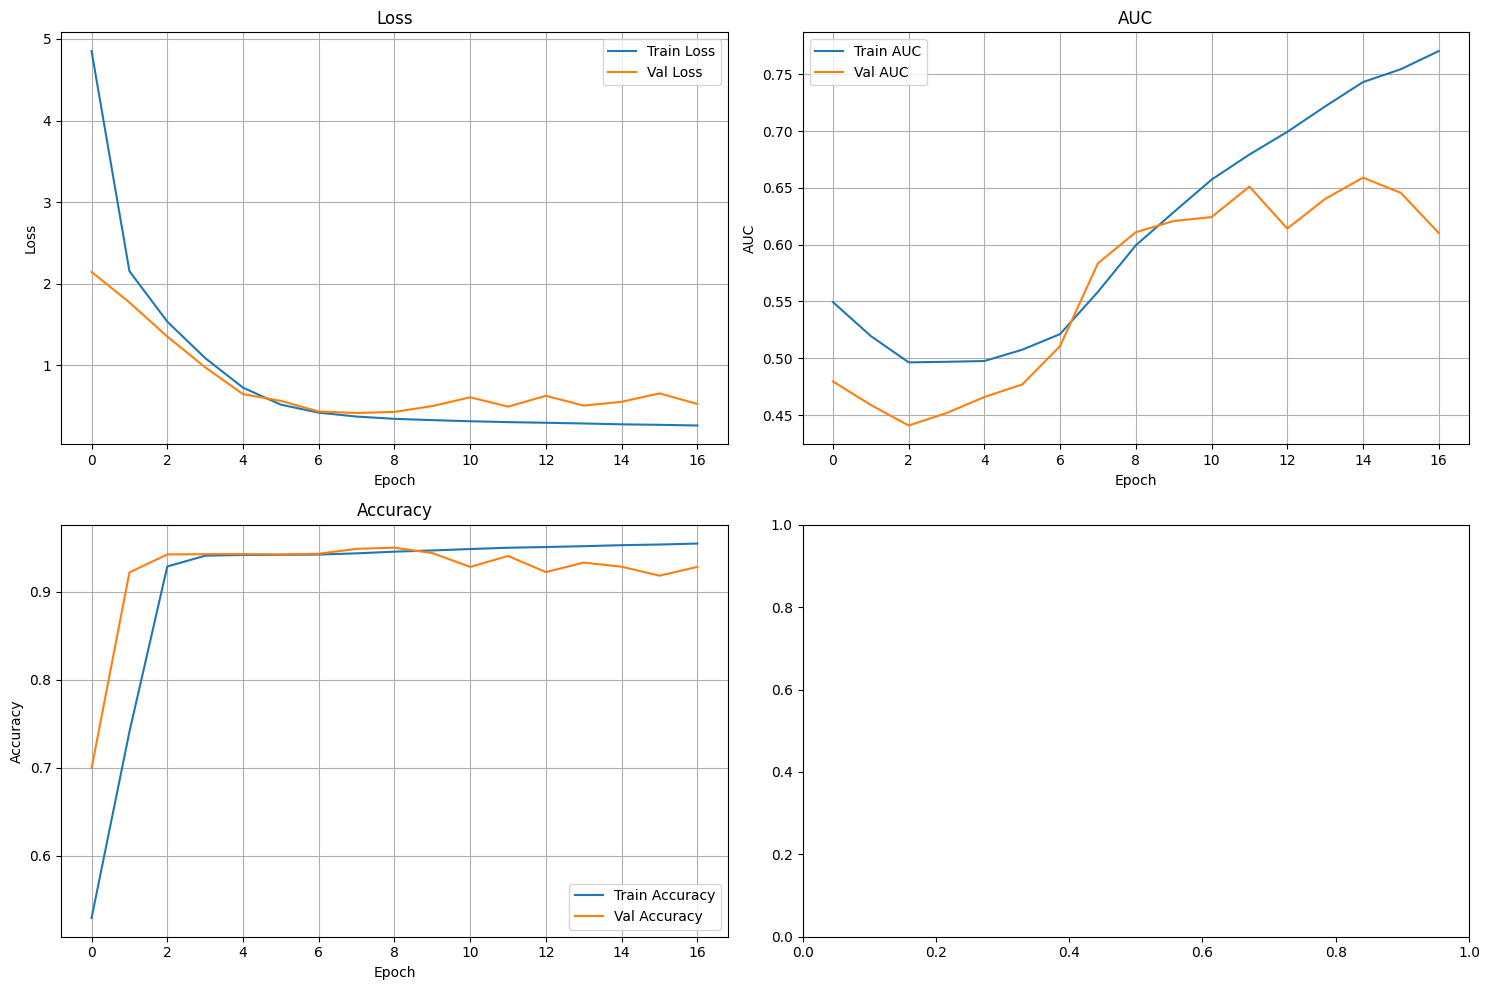

✓ Training curves saved to /dataset/multilabel_19v3//training_history.png


In [32]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss')
axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
axes[0, 0].set_title('Loss', fontsize=12)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# AUC
axes[0, 1].plot(history.history['auc'], label='Train AUC')
axes[0, 1].plot(history.history['val_auc'], label='Val AUC')
axes[0, 1].set_title('AUC', fontsize=12)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Accuracy
axes[1, 0].plot(history.history['accuracy'], label='Train Accuracy')
axes[1, 0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[1, 0].set_title('Accuracy', fontsize=12)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Precision & Recall
# axes[1, 1].plot(history.history['precision'], label='Train Precision', linestyle='--')
# axes[1, 1].plot(history.history['recall'], label='Train Recall', linestyle=':')
# axes[1, 1].plot(history.history['val_precision'], label='Val Precision', linestyle='--')
# axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linestyle=':')
# axes[1, 1].set_title('Precision & Recall', fontsize=12)
# axes[1, 1].set_xlabel('Epoch')
# axes[1, 1].set_ylabel('Score')
# axes[1, 1].legend()
# axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_history.png'), dpi=150)
plt.show()

print(f"✓ Training curves saved to {OUTPUT_DIR}/training_history.png")

## 8. Evaluation with Disease Names

In [33]:
# Get predictions on test set (OPTIMIZED)
print("Generating predictions on test set...")

# Calculate test steps
test_samples = len(test_idx)
test_steps = test_samples // BATCH_SIZE + (1 if test_samples % BATCH_SIZE != 0 else 0)

print(f"Test samples: {test_samples}")
print(f"Test steps: {test_steps}")
print(f"Batch size: {BATCH_SIZE}")

# Get ground truth labels
y_true_test = lazy_loader.y_all[test_idx]

# Predict with specified steps to avoid infinite loop
y_pred_proba_test = model.predict(
    test_dataset,
    steps=test_steps,  # CRITICAL: specify steps
    verbose=1
    )

# Trim predictions to match actual test size (in case of padding)
y_pred_proba_test = y_pred_proba_test[:test_samples]

# Convert probabilities to binary predictions
y_pred_test = (y_pred_proba_test > 0.5).astype(int)

print(f"\n✓ Predictions complete")
print(f"  Test samples: {len(y_true_test)}")
print(f"  Predictions shape: {y_pred_proba_test.shape}")

Generating predictions on test set...
Test samples: 2129
Test steps: 17
Batch size: 128
17/17 ━━━━━━━━━━━━━━━━━━━━ 1142s 66s/step

✓ Predictions complete
  Test samples: 2129
  Predictions shape: (2129, 19)


In [34]:
# Overall metrics
print("="*80)
print("OVERALL TEST METRICS")
print("="*80)

# Subset accuracy (exact match)
subset_acc = np.mean(np.all(y_true_test == y_pred_test, axis=1))
print(f"Subset Accuracy (Exact Match): {subset_acc:.4f}")

# Hamming loss
hamming = hamming_loss(y_true_test, y_pred_test)
print(f"Hamming Loss: {hamming:.4f}")

# F1 scores
f1_micro = f1_score(y_true_test, y_pred_test, average='micro', zero_division=0)
f1_macro = f1_score(y_true_test, y_pred_test, average='macro', zero_division=0)
f1_weighted = f1_score(y_true_test, y_pred_test, average='weighted', zero_division=0)

print(f"F1-Score (Micro):    {f1_micro:.4f}")
print(f"F1-Score (Macro):    {f1_macro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")

# Precision & Recall
prec_micro = precision_score(y_true_test, y_pred_test, average='micro', zero_division=0)
rec_micro = recall_score(y_true_test, y_pred_test, average='micro', zero_division=0)

print(f"Precision (Micro):   {prec_micro:.4f}")
print(f"Recall (Micro):      {rec_micro:.4f}")

OVERALL TEST METRICS
Subset Accuracy (Exact Match): 0.0559
Hamming Loss: 0.0778
F1-Score (Micro):    0.0849
F1-Score (Macro):    0.0127
F1-Score (Weighted): 0.1096
Precision (Micro):   0.1199
Recall (Micro):      0.0657


In [35]:
# Per-class metrics with DISEASE NAMES ONLY (no ICD codes)
print("\n" + "="*80)
print("PER-CLASS METRICS (Grouped by Disease Category)")
print("="*80)

per_class_results = {}

# Group by disease category
for group_name, group_icds in DISEASE_GROUPS.items():
    print(f"\n{group_name.upper()}:")
    print("-" * 80)

    for icd in group_icds:
        if icd not in ICD_CODES:
            continue

        idx = ICD_CODES.index(icd)
        disease_name = DISEASE_NAMES[idx]  # Get disease name

        y_true_class = y_true_test[:, idx]
        y_pred_class = y_pred_test[:, idx]
        y_pred_proba_class = y_pred_proba_test[:, idx]

        support = int(y_true_class.sum())

        if support > 0:
            precision = precision_score(y_true_class, y_pred_class, zero_division=0)
            recall = recall_score(y_true_class, y_pred_class, zero_division=0)
            f1 = f1_score(y_true_class, y_pred_class, zero_division=0)

            try:
                roc_auc = roc_auc_score(y_true_class, y_pred_proba_class)
            except:
                roc_auc = 0.0

            per_class_results[disease_name] = {
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'roc_auc': roc_auc,
                'support': support
            }

            # Print ONLY disease name (no ICD code)
            print(f"\n{disease_name}:")  # Changed from showing ICD code
            print(f"  Support:   {support:4d}")
            print(f"  Precision: {precision:.4f}")
            print(f"  Recall:    {recall:.4f}")
            print(f"  F1-Score:  {f1:.4f}")
            print(f"  ROC-AUC:   {roc_auc:.4f}")

# Healthy class
print(f"\nHEALTHY:")
print("-" * 80)

idx = ICD_CODES.index('Healthy')
disease_name = DISEASE_NAMES[idx]  # "Healthy"

y_true_class = y_true_test[:, idx]
y_pred_class = y_pred_test[:, idx]
y_pred_proba_class = y_pred_proba_test[:, idx]

support = int(y_true_class.sum())

if support > 0:
    precision = precision_score(y_true_class, y_pred_class, zero_division=0)
    recall = recall_score(y_true_class, y_pred_class, zero_division=0)
    f1 = f1_score(y_true_class, y_pred_class, zero_division=0)

    try:
        roc_auc = roc_auc_score(y_true_class, y_pred_proba_class)
    except:
        roc_auc = 0.0

    per_class_results[disease_name] = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'support': support
    }

    print(f"\n{disease_name}:")  # Just "Healthy"
    print(f"  Support:   {support:4d}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")


PER-CLASS METRICS (Grouped by Disease Category)

MYOCARDITIS:
--------------------------------------------------------------------------------

Acute Myocarditis:
  Support:     11
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  ROC-AUC:   0.5459

Myocarditis Unspecified:
  Support:     28
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  ROC-AUC:   0.5061

CARDIOMYOPATHY:
--------------------------------------------------------------------------------

Dilated Cardiomyopathy:
  Support:     14
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  ROC-AUC:   0.2942

Hypertrophic Cardiomyopathy:
  Support:      3
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  ROC-AUC:   0.3501

Cardiomyopathy Unspecified:
  Support:      2
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  ROC-AUC:   0.3684

Noncompaction Ventricular Myocardium:
  Support:      3
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  ROC-AUC:   0.7858



## 9. Prediction Visualization

In [36]:
def show_prediction_with_names(sample_idx, threshold=0.5):
    """
    Display prediction with DISEASE NAMES ONLY (no ICD codes).
    """
    print(f"\n{'='*80}")
    print(f"Sample {sample_idx + 1}")
    print(f"{'='*80}")

    # Get data
    test_sample_idx = test_idx[sample_idx]
    y_true = y_true_test[sample_idx]
    y_pred_proba = y_pred_proba_test[sample_idx]

    # True labels - DISEASE NAMES ONLY
    true_indices = np.where(y_true == 1)[0]
    print(f"\nTrue Diagnoses ({len(true_indices)}):")
    if len(true_indices) > 0:
        for idx in true_indices:
            print(f"  - {DISEASE_NAMES[idx]}")  # ONLY disease name
    else:
        print("  - None")

    # Predicted labels - DISEASE NAMES ONLY
    pred_indices = np.where(y_pred_proba > threshold)[0]
    print(f"\nPredicted Diagnoses (threshold={threshold}):")
    if len(pred_indices) > 0:
        for idx in sorted(pred_indices, key=lambda i: -y_pred_proba[i]):
            prob = y_pred_proba[idx]
            marker = "✓" if y_true[idx] == 1 else " "
            print(f"  {marker} {DISEASE_NAMES[idx]}: {prob:.4f}")  # ONLY disease name
    else:
        print("  - None")

    # Top 5 predictions - DISEASE NAMES ONLY
    print(f"\nTop 5 Predictions (all probabilities):")
    top_5 = np.argsort(y_pred_proba)[-5:][::-1]
    for idx in top_5:
        prob = y_pred_proba[idx]
        marker = "✓" if y_true[idx] == 1 else " "
        print(f"  {marker} {DISEASE_NAMES[idx]}: {prob:.4f}")  # ONLY disease name


# Show predictions for random samples
print("\nSample Predictions:")
random_samples = np.random.choice(len(test_idx), size=min(5, len(test_idx)), replace=False)
for i in random_samples:
    show_prediction_with_names(i)


Sample Predictions:

Sample 1030

True Diagnoses (1):
  - Healthy

Predicted Diagnoses (threshold=0.5):
  - None

Top 5 Predictions (all probabilities):
    Congenital Heart Malformation: 0.4339
    Pulmonary Artery Stenosis: 0.3693
    Noncompaction Ventricular Myocardium: 0.3009
    Cardiomyopathy Unspecified: 0.2161
    Dilated Cardiomyopathy: 0.2147

Sample 1148

True Diagnoses (1):
  - Healthy

Predicted Diagnoses (threshold=0.5):
  - None

Top 5 Predictions (all probabilities):
    Congenital Heart Malformation: 0.4721
    Pulmonary Artery Stenosis: 0.3748
    Noncompaction Ventricular Myocardium: 0.3711
    Dilated Cardiomyopathy: 0.3031
    Pulmonary Valve Stenosis: 0.2237

Sample 439

True Diagnoses (1):
  - Healthy

Predicted Diagnoses (threshold=0.5):
  - None

Top 5 Predictions (all probabilities):
    Cardiomyopathy Unspecified: 0.3692
    Tetralogy of Fallot: 0.3011
    Pulmonary Valve Stenosis: 0.2821
    Noncompaction Ventricular Myocardium: 0.2731
    Kawasaki Disease


ECG Signal Visualizations:


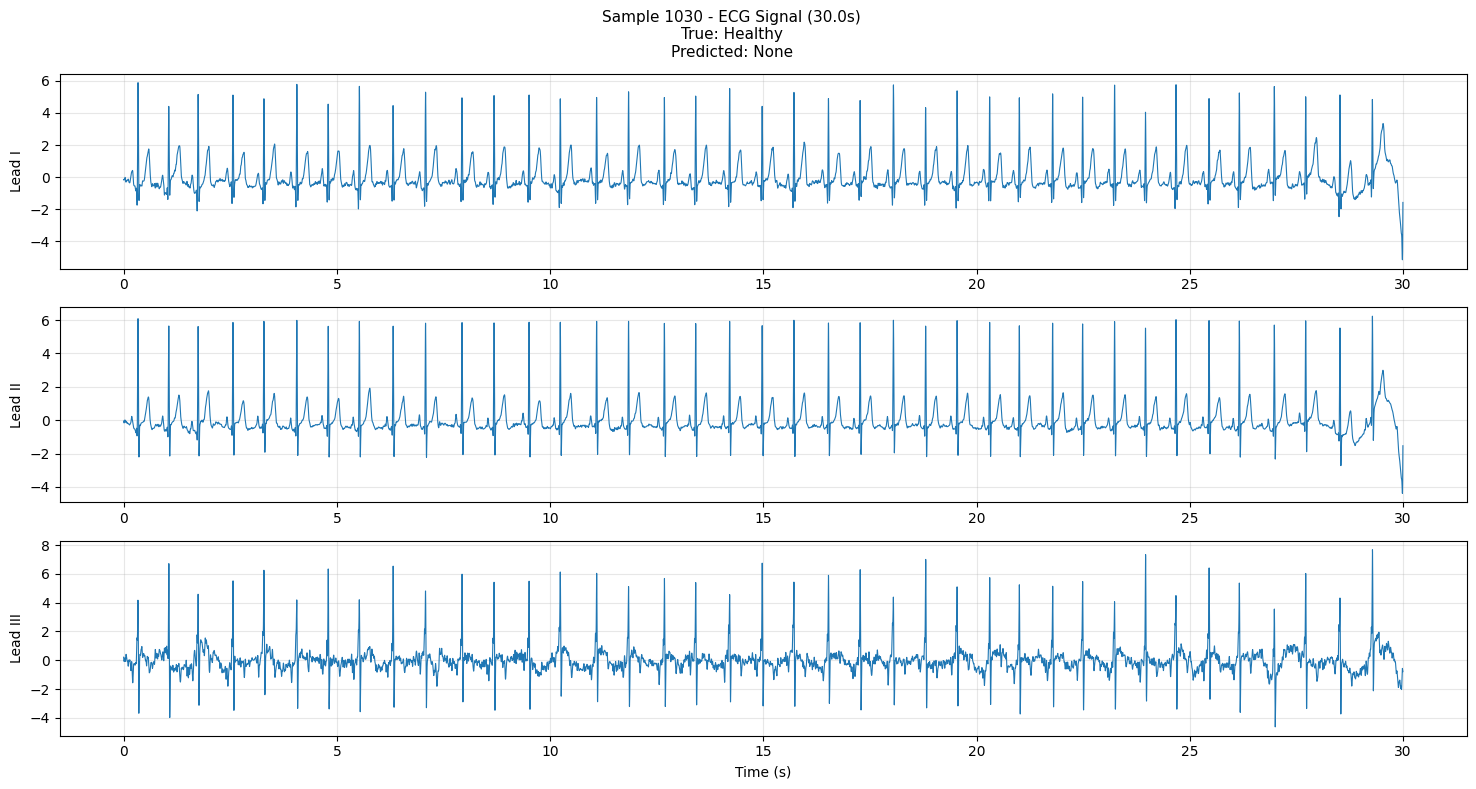

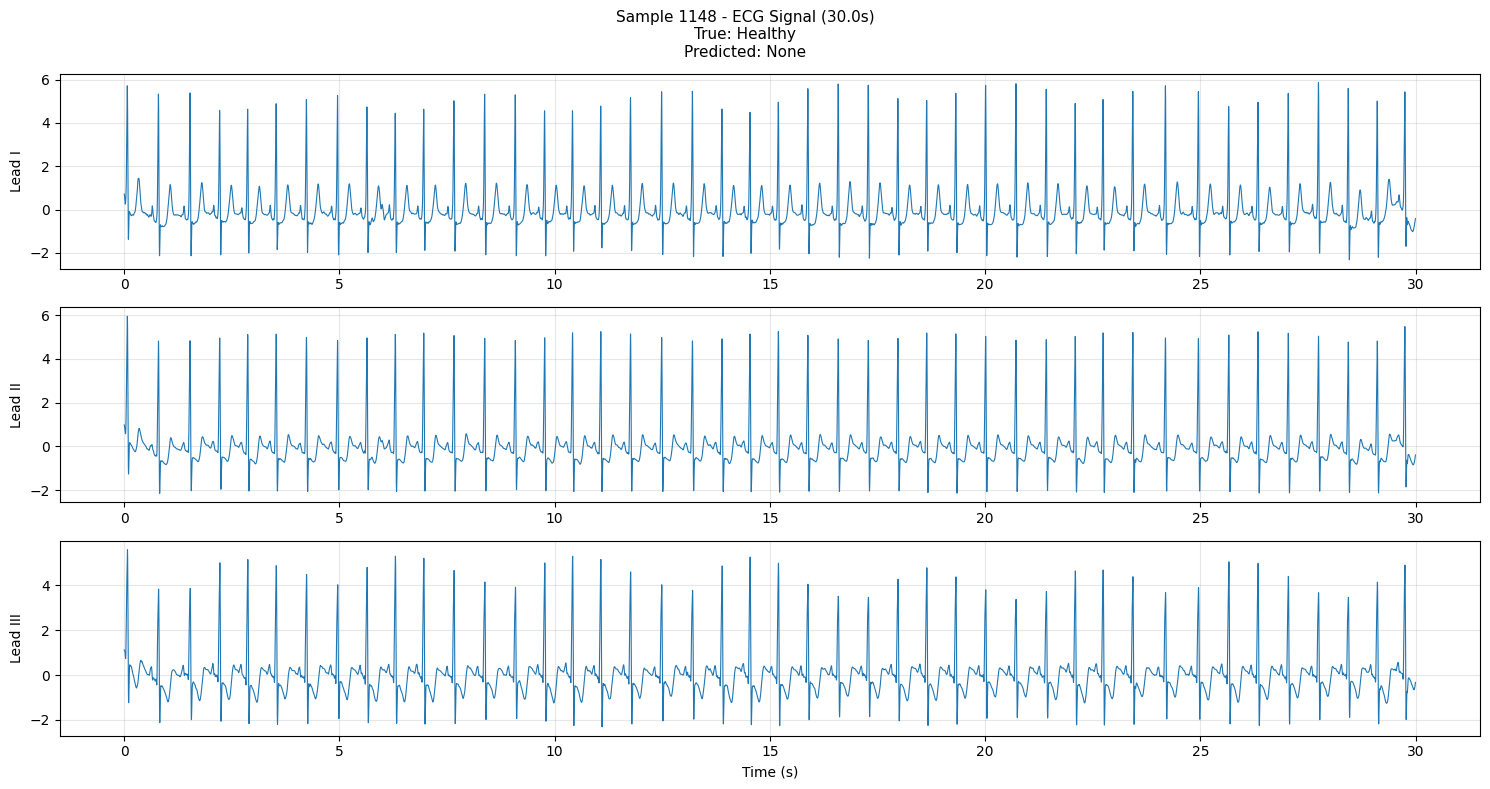

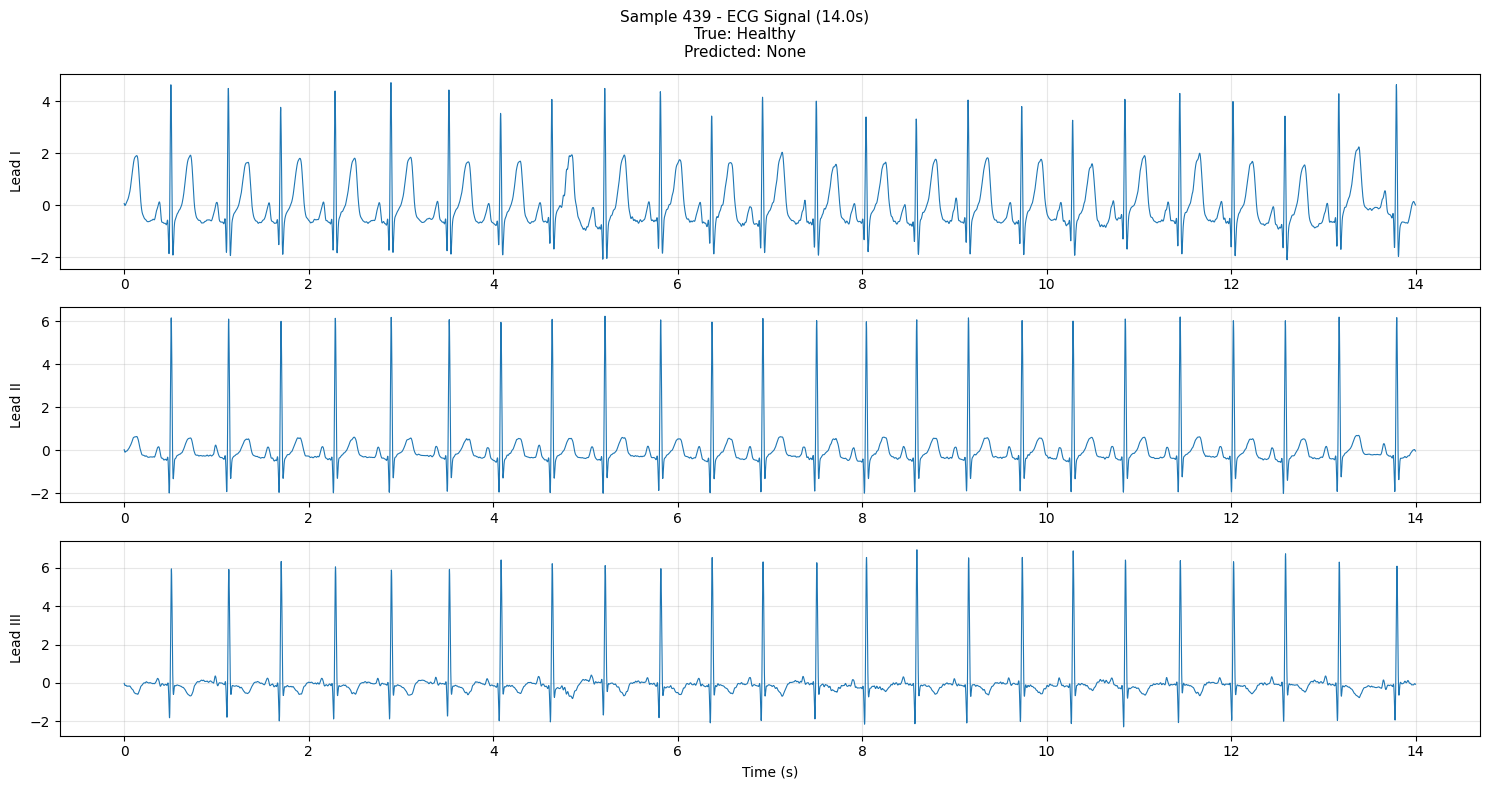

In [37]:
# Plot ECG signal with predictions
def plot_ecg_with_predictions(sample_idx, num_leads=3):
    """
    Plot ECG signal with true and predicted labels (DISEASE NAMES ONLY).
    """
    test_sample_idx = test_idx[sample_idx]
    # Use lazy_loader to get the ECG signal (X_data is not defined)
    ecg_signal, _, _ = lazy_loader[test_sample_idx]
    y_true = y_true_test[sample_idx]
    y_pred_proba = y_pred_proba_test[sample_idx]

    # Get disease names
    true_labels = [DISEASE_NAMES[j] for j in range(NUM_CLASSES) if y_true[j] == 1]
    pred_labels = [(DISEASE_NAMES[j], y_pred_proba[j])
                  for j in range(NUM_CLASSES) if y_pred_proba[j] > 0.5]

    # Plot
    fig, axes = plt.subplots(num_leads, 1, figsize=(15, 8))
    if num_leads == 1:
        axes = [axes]

    time = np.arange(len(ecg_signal)) / TARGET_FS
    lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    for i in range(num_leads):
        axes[i].plot(time, ecg_signal[:, i], linewidth=0.8)
        axes[i].set_ylabel(f'Lead {lead_names[i]}', fontsize=10)
        axes[i].grid(True, alpha=0.3)

    axes[-1].set_xlabel('Time (s)', fontsize=10)

    # Title with disease names
    title = f'Sample {sample_idx + 1} - ECG Signal ({len(ecg_signal)/TARGET_FS:.1f}s)\n'
    title += f'True: {", ".join(true_labels) if true_labels else "None"}\n'
    if pred_labels:
        pred_str = ", ".join([f"{l} ({p:.2f})" for l, p in pred_labels])
        title += f'Predicted: {pred_str}'
    else:
        title += 'Predicted: None'

    plt.suptitle(title, fontsize=11, y=0.98)
    plt.tight_layout()
    plt.show()


# Plot a few examples
print("\nECG Signal Visualizations:")
for i in random_samples[:3]:
    plot_ecg_with_predictions(i, num_leads=3)

## 10. Save Model & Metadata

In [38]:
# Save final model
final_model_path = os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_final.keras')
model.save(final_model_path)
print(f"✓ Model saved to {final_model_path}")

# Save comprehensive metadata with DISEASE NAMES
results_metadata = {
    'model_name': MODEL_NAME,
    'version': NOTEBOOK_VERSION,
    'created': datetime.now().isoformat(),

    # Classes - DISEASE NAMES ONLY in main list
    'num_classes': NUM_CLASSES,
    'disease_names': DISEASE_NAMES,  # Main output list - names only
    'icd_codes': ICD_CODES,  # Reference only
    'icd_to_disease_name': ICD_TO_DISEASE_NAME,  # Mapping reference
    'disease_groups': DISEASE_GROUPS,

    # Architecture
    'architecture': {
        'type': 'Enhanced 1D CNN',
        'blocks': '64→128→256→512 filters',
        'features': ['Squeeze-Excitation', 'Temporal Attention', 'Residual Connections'],
        'pooling': 'Adaptive (Global Avg + Max)',
        'total_params': int(model.count_params())
    },

    # Training
    'training': {
        'epochs': len(history.history['loss']),
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'loss': 'Focal Loss (alpha=0.25, gamma=2.0)',
        'optimizer': 'Adam'
    },

    # Data - use lazy_loader instead of X_data/lengths_data
    'data': {
        'total_samples': len(lazy_loader),
        'train_samples': len(train_idx),
        'val_samples': len(val_idx),
        'test_samples': len(test_idx),
        'sampling_rate': TARGET_FS,
        'num_channels': TARGET_CHANNELS,
        'variable_length': True,
        'length_range': f"{lazy_loader.lengths_all.min()/TARGET_FS:.1f}s - {lazy_loader.lengths_all.max()/TARGET_FS:.1f}s"
    },

    # Test metrics
    'test_metrics': {
        'subset_accuracy': float(subset_acc),
        'hamming_loss': float(hamming),
        'f1_micro': float(f1_micro),
        'f1_macro': float(f1_macro),
        'f1_weighted': float(f1_weighted),
        'precision_micro': float(prec_micro),
        'recall_micro': float(rec_micro)
    },

    # Per-class results (DISEASE NAMES ONLY)
    'per_class_results': per_class_results
}

# Save metadata
metadata_path = os.path.join(OUTPUT_DIR, 'model_results.json')
with open(metadata_path, 'w') as f:
    json.dump(results_metadata, f, indent=2)

print(f"✓ Metadata saved to {metadata_path}")

# Upload to HuggingFace (if enabled)
if ENABLE_HF_UPLOAD and MODEL_REPO and api:
    print(f"\nUploading final model to HuggingFace...")

    try:
        # Upload model
        api.upload_file(
            path_or_fileobj=final_model_path,
            path_in_repo="final_model.keras",
            repo_id=MODEL_REPO,
            repo_type="model",
            commit_message="Final trained model"
        )
        print("✓ Final model uploaded")

        # Upload metadata
        api.upload_file(
            path_or_fileobj=metadata_path,
            path_in_repo="model_results.json",
            repo_id=MODEL_REPO,
            repo_type="model",
            commit_message="Add model metadata"
        )
        print("✓ Metadata uploaded")

        # Upload training history
        history_csv = os.path.join(OUTPUT_DIR, 'training_history.csv')
        if os.path.exists(history_csv):
            api.upload_file(
                path_or_fileobj=history_csv,
                path_in_repo="training_history.csv",
                repo_id=MODEL_REPO,
                repo_type="model",
                commit_message="Add training history"
            )
            print("✓ Training history uploaded")

        # Upload training plot
        history_plot = os.path.join(OUTPUT_DIR, 'training_history.png')
        if os.path.exists(history_plot):
            api.upload_file(
                path_or_fileobj=history_plot,
                path_in_repo="training_history.png",
                repo_id=MODEL_REPO,
                repo_type="model",
                commit_message="Add training visualization"
            )
            print("✓ Training visualization uploaded")

        print(f"\n{'='*60}")
        print(f"✓ All artifacts uploaded to HuggingFace!")
        print(f"View at: https://huggingface.co/{MODEL_REPO}")
        print(f"{'='*60}")

    except Exception as e:
        print(f"Warning: Could not upload to HF: {e}")

print("\n" + "="*80)
print("TRAINING COMPLETE!")
print("="*80)
print(f"Model: {final_model_path}")
print(f"Metadata: {metadata_path}")
print(f"Training history: {os.path.join(OUTPUT_DIR, 'training_history.csv')}")
print(f"\nTest F1-Score (Macro): {f1_macro:.4f}")

✓ Model saved to /dataset/multilabel_19v3/1D_CNN_19Classes_multilabel_19v3_final.keras
✓ Metadata saved to /dataset/multilabel_19v3/model_results.json

Uploading final model to HuggingFace...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ltilabel_19v3_final.keras:  12%|#2        |  580kB / 4.65MB            

✓ Final model uploaded
✓ Metadata uploaded


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...19v3/training_history.png: 100%|##########|  154kB /  154kB            

✓ Training visualization uploaded

✓ All artifacts uploaded to HuggingFace!
View at: https://huggingface.co/Neural-Network-Project/ECG-Disease-Classifier

TRAINING COMPLETE!
Model: /dataset/multilabel_19v3/1D_CNN_19Classes_multilabel_19v3_final.keras
Metadata: /dataset/multilabel_19v3/model_results.json
Training history: /dataset/multilabel_19v3/training_history.csv

Test F1-Score (Macro): 0.0127


## 11. Generate Model Card (HuggingFace)

In [39]:
# Generate model card for HuggingFace (if enabled)
if ENABLE_HF_UPLOAD and MODEL_REPO:
    disease_names_str = '\n'.join([f"{i+1}. {name}" for i, name in enumerate(DISEASE_NAMES)])

    model_card = f"""---
language: en
tags:
- ecg
- cardiology
- medical
- pediatric
- time-series
- multi-label-classification
- tensorflow
- cnn
datasets:
- Neural-Network-Project/ECG-database
metrics:
- f1
- auc
- precision
- recall
library_name: tensorflow
---

# ECG Disease Classifier - 19 Cardiac Conditions

Multi-label classification model for detecting 19 cardiac conditions from pediatric ECG signals.

## Model Description

Enhanced 1D CNN with Squeeze-Excitation blocks and temporal attention for variable-length ECG classification.

**Architecture:** 64→128→256→512 filters with residual connections
**Training:** Focal loss for class imbalance
**Input:** Variable-length 12-lead ECG (5-120 seconds at 500 Hz)

## Disease Classes

{disease_names_str}

## Performance

- F1-Score (Macro): {f1_macro:.4f}
- F1-Score (Micro): {f1_micro:.4f}
- Subset Accuracy: {subset_acc:.4f}

## Intended Use

⚠️ **Research and educational purposes only** - NOT for clinical diagnosis

## Training Details

- Batch Size: {BATCH_SIZE}
- Epochs: {len(history.history['loss'])}
- Loss: Focal Loss (α=0.25, γ=2.0)
- Optimizer: Adam (lr={LEARNING_RATE})

## Citation

```bibtex
@misc{{ecg-classifier-2025,
  author = {{Neural-Network-Project}},
  title = {{ECG Disease Classifier}},
  year = {{2025}},
  publisher = {{Hugging Face}},
  url = {{https://huggingface.co/{MODEL_REPO}}}
}}
```
"""

    # Save locally
    readme_path = os.path.join(OUTPUT_DIR, 'README.md')
    with open(readme_path, 'w') as f:
        f.write(model_card)

    print("✓ Model card created")

    # Upload to HuggingFace
    try:
        api.upload_file(
            path_or_fileobj=readme_path,
            path_in_repo="README.md",
            repo_id=MODEL_REPO,
            repo_type="model",
            commit_message="Add model card"
        )
        print("✓ Model card uploaded to HuggingFace")
    except Exception as e:
        print(f"Warning: Could not upload model card: {e}")
else:
    print("Skipping model card generation (ENABLE_HF_UPLOAD=False)")

✓ Model card created
✓ Model card uploaded to HuggingFace


## Summary

This notebook implements an enhanced 1D CNN for 19-class multi-label ECG classification:

**Key Features:**
- ✅ Processes full-length variable recordings (5-120 seconds, no windowing)
- ✅ 19 classes (18 cardiac diseases + Healthy)
- ✅ Enhanced architecture with SE blocks and temporal attention
- ✅ Focal loss for class imbalance
- ✅ **All outputs show disease names only** (not ICD codes)

**Architecture:**
- 64→128→256→512 filters with residual connections
- Squeeze-Excitation blocks for channel attention
- Temporal attention for time-series focus
- Adaptive pooling for variable lengths

**Next Steps:**
- Fine-tune threshold per class
- Analyze attention weights
- Deploy for inference